In [45]:
import scanpy as sc
import pandas as pd

In [364]:
def merge(
    h5ad_file: str,
    csv_files: dict,
    # Output h5ad settings
    path:str,   # User define
    file_name:str,
):

    # 加载 h5ad 文件
    adata = sc.read_h5ad(h5ad_file)
    print(f"[INFO] There is {adata.obs.shape[0]} cells in the h5ad before merging.")
    
    adata.obs['cdr3'] = '/'
    adata.obs['cdr3_nt'] = '/'
    adata.obs['V_gene'] = '/'
    adata.obs['D_gene'] = '/'
    adata.obs['J_gene'] = '/'
    adata.obs['C_gene'] = '/'
    adata.obs['barcode'] = [i[:16] for i in adata.obs.index]
    # print(adata.obs)
    
    match = {}
    
    for sample_name, csv_file in csv_files.items():

        mask_batch = adata.obs['batch'] == sample_name
        num_duplicates = adata.obs.loc[mask_batch, "barcode"].duplicated().sum()
        print(f"Number of duplicate barcodes in h5ad: {num_duplicates} for batch {sample_name}")
        assert(num_duplicates == 0)
        
        # 加载 csv 文件
        csv_data = pd.read_csv(csv_file, sep=',')  # 假设用','分隔

        # 计算'barcode'列中重复值的数量
        num_duplicates = csv_data['barcode'].duplicated().sum()

        print(f"Number of duplicate barcodes in csv: {num_duplicates}")

        add = 0
        match_list = []
        
        # 遍历csv_data中的每一行
        for _, row in csv_data.iterrows():
            # 查找adata.obs中barcode和batch与csv_data匹配的行
            # print(row['barcode'])
            mask = (((adata.obs['barcode'] == row['barcode'][:16])) & (adata.obs['batch'] == sample_name))
            # 如果找到匹配的行，更新cdr3和cdr3_nt
            if mask.any():
                for item in adata.obs.loc[mask].index:
                    match_list.append(item)
                    if(len(match_list) % 200 == 0):
                        print(len(match_list),'matched!')
                if(len(adata.obs.loc[mask]) == 1 & pd.isna(adata.obs.loc[mask]['cdr3'][-1])):
                    # print('This: ')
                    # print(adata.obs.loc[mask])
                    adata.obs.loc[mask, 'cdr3'] = row['cdr3']
                    adata.obs.loc[mask, 'cdr3_nt'] = row['cdr3_nt']
                    adata.obs.loc[mask, 'V_gene'] = row['v_gene']
                    adata.obs.loc[mask, 'D_gene'] = row['d_gene']
                    adata.obs.loc[mask, 'J_gene'] = row['j_gene']
                    adata.obs.loc[mask, 'C_gene'] = row['c_gene']

                    # print(adata.obs)
                else:
                    add += 1
                    # 复制第一行的obs信息
                    # print('That: ')
                    # print(adata.obs.loc[mask].iloc[0].copy().to_frame().T.shape)
                    first_row_copy = adata.obs.loc[mask].iloc[0].copy().to_frame().T
                    first_row_copy['cdr3'] = row['cdr3']
                    first_row_copy['cdr3_nt'] = row['cdr3_nt']
                    first_row_copy['V_gene'] = row['v_gene']
                    first_row_copy['D_gene'] = row['d_gene']
                    first_row_copy['J_gene'] = row['j_gene']
                    first_row_copy['C_gene'] = row['c_gene']
                    first_row_copy['batch'] = first_row_copy['batch'] + "-copy"

                    # 生成新的X行（数据），这里假设全零，形状与adata的变量数相同
                    new_data_row = adata.X[mask][:1]

                    # 将新的obs行和新的X行添加到adata
                    # 由于直接添加可能引起问题，我们创建一个新的AnnData对象
                    new_obs = pd.concat([adata.obs, first_row_copy], ignore_index=True)
                    new_X = np.vstack([adata.X, new_data_row])

                    # 创建一个新的AnnData对象
                    new_adata = ad.AnnData(X=new_X, obs=new_obs, var=adata.var)
                    #print(new_adata.obs)

                    adata = new_adata    
                
                    
        match[sample_name] = match_list
        print(f'{sample_name}: {len(set(match_list))} lines matched!')
        print(f'{sample_name}: {add} lines added!')

    for key in ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'discard', 'True', 'batch', 'leiden', 'louvain', 'cell_type', 'cdr3', 'cdr3_nt', 'barcode', 'V_gene']:
        adata.obs[key] = adata.obs[key].astype(str)
    print(f"[INFO] There is {adata.obs.shape[0]} cells in the h5ad now.")
    adata.write_h5ad(path+file_name+'.h5ad')
    print('[INFO] File saved!')
    print('[INFO] Modifying cell_type using TRUST output...')
    
    # 检查'gene'列以"IG"开头的所有行，同时确保排除任何NA/NaN值
    mask = adata.obs['V_gene'].str.startswith('IG')
    # 将这些行的'cell_type'列改为"B cell"
    adata.obs.loc[mask, 'cell_type'] = 'B cell'
    adata.write_h5ad(path+file_name+'_modified'+'.h5ad')
    print('[INFO] Modified file saved!')
    
    adata.file.close()  # 关闭备份文件
        
    return adata,match

In [ ]:
import numpy as np
import anndata as ad
import warnings
from anndata import ImplicitModificationWarning

# 忽略特定类型的警告
warnings.filterwarnings('ignore', category=ImplicitModificationWarning)

adata,match = merge(h5ad_file = '/home/zengzw/HRA000704_results/count/Tumor/tumor_clustering.h5ad', 
              csv_files = {'GC01-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147435_BCR/outs/filtered_contig_annotations.csv',
                            'GC02-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147436_BCR/outs/filtered_contig_annotations.csv',
                            'GC03-Tumor-rep1':'/home/zengzw/HRA000704_outs/vdj/HRS147439_BCR/outs/filtered_contig_annotations.csv',
                            'GC03-Tumor-rep2':'/home/zengzw/HRA000704_outs/vdj/HRS147439_BCR_rep/outs/filtered_contig_annotations.csv',
                            'GC04-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147441_BCR/outs/filtered_contig_annotations.csv',

                            'GC05-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147443_BCR/outs/filtered_contig_annotations.csv',
                            'GC06-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147446_BCR/outs/filtered_contig_annotations.csv',
                            'GC07-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147449_BCR/outs/filtered_contig_annotations.csv',
                            'GC08-Tumor-S1':'/home/zengzw/HRA000704_outs/vdj/HRS147452_BCR/outs/filtered_contig_annotations.csv',
                            'GC08-Tumor-S2':'/home/zengzw/HRA000704_outs/vdj/HRS147453_BCR/outs/filtered_contig_annotations.csv',
                           
                            'GC09-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147455_BCR/outs/filtered_contig_annotations.csv',
                            'GC10-Tumor':'/home/zengzw/HRA000704_outs/vdj/HRS147458_BCR/outs/filtered_contig_annotations.csv',                          },
              path = '/home/zengzw/HRA000704_results',
              file_name = '/2_GC_HRA000704_tumor',
    )

[INFO] There is 55194 cells in the h5ad before merging.
Number of duplicate barcodes in h5ad: 0 for batch GC01-Tumor
Number of duplicate barcodes in csv: 231
200 matched!
GC01-Tumor: 206 lines matched!
GC01-Tumor: 376 lines added!
Number of duplicate barcodes in h5ad: 0 for batch GC02-Tumor
Number of duplicate barcodes in csv: 502
200 matched!
400 matched!
600 matched!
800 matched!
GC02-Tumor: 460 lines matched!
GC02-Tumor: 912 lines added!
Number of duplicate barcodes in h5ad: 0 for batch GC03-Tumor-rep1
Number of duplicate barcodes in csv: 1098
200 matched!
400 matched!
600 matched!
800 matched!
1000 matched!
1200 matched!
1400 matched!
1600 matched!
1800 matched!
2000 matched!
2200 matched!
GC03-Tumor-rep1: 1194 lines matched!
GC03-Tumor-rep1: 2203 lines added!
Number of duplicate barcodes in h5ad: 0 for batch GC03-Tumor-rep2
Number of duplicate barcodes in csv: 1232
200 matched!
400 matched!
600 matched!
800 matched!
1000 matched!
1200 matched!
1400 matched!
1600 matched!
1800 matc

In [367]:
for key in ['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'discard', 'True', 'batch', 'leiden', 'louvain', 'cell_type', 'cdr3', 'cdr3_nt', 'barcode', 'V_gene']:
    adata.obs[key] = adata.obs[key].astype(str)
adata.write_h5ad('/home/zengzw/GC_Zenglab'+'.h5ad')
print('[INFO] File saved!')
print('[INFO] Modifying cell_type using TRUST output...')
    
    #检查'gene'列以"IG"开头的所有行，同时确保排除任何NA/NaN值
mask = adata.obs['V_gene'].str.startswith('IG')
    # 将这些行的'cell_type'列改为"B cell"
adata.obs.loc[mask, 'cell_type'] = 'B cell'
adata.write_h5ad(path+file_name+'_modified'+'.h5ad')
print('[INFO] Modified file saved!')



[INFO] File saved!
[INFO] Modifying cell_type using TRUST output...
[INFO] Modified file saved!


In [368]:
adata.obs.shape[0]

21019

In [369]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,discard,True,batch,leiden,louvain,cell_type,cdr3,cdr3_nt,V_gene,D_gene,J_gene,C_gene,barcode
0,2225,5596.0,80.0,1.429592490196228,True,5596.0,HAS01,0,1,T cell,/,/,/,/,/,/,AAACCTGAGCCACGCT
1,1370,3107.0,74.0,2.381718635559082,True,3107.0,HAS01,0,9,T cell,/,/,/,/,/,/,AAACCTGAGCTGCGAA
2,1890,4744.0,142.0,2.9932546615600586,True,4744.0,HAS01,10,11,NK cell,/,/,/,/,/,/,AAACCTGAGGTGACCA
3,1574,3186.0,20.0,0.6277464032173157,True,3186.0,HAS01,0,1,T cell,/,/,/,/,/,/,AAACCTGCAAACTGCT
4,1158,2202.0,125.0,5.676657676696777,True,2202.0,HAS01,4,3,B cell,/,/,/,/,/,/,AAACCTGCAAATACAG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21014,2791,22018.0,61.0,0.2770460546016693,True,22018.0,HAS05-copy,9,10,B cell,CARENTDESGSDFNWLDPW,TGTGCGAGGGAGAACACAGATGAATCGGGAAGTGATTTTAATTGGC...,IGHV4-4,NaN,IGHJ5,IGHG1,TTTGGTTCAAGGTGTG
21015,2791,22018.0,61.0,0.2770460546016693,True,22018.0,HAS05-copy,9,10,B cell,CQQSYNTRTF,TGTCAACAGAGTTACAATACCCGGACGTTC,IGKV1D-39,NaN,IGKJ1,IGKC,TTTGGTTCAAGGTGTG
21016,1313,3271.0,322.0,9.844083786010742,True,3271.0,HAS05-copy,4,3,B cell,CASAKTTLYSFDYW,TGTGCGAGCGCGAAAACAACTTTGTACTCCTTTGACTACTGG,IGHV4-39,NaN,IGHJ4,IGHM,TTTGGTTGTCCGAATT
21017,4573,27415.0,139.0,0.5070216655731201,True,27415.0,HAS05-copy,17,14,B cell,CAAWDDSLYGWVF,TGTGCAGCATGGGATGACAGCCTCTATGGTTGGGTGTTC,IGLV1-44,NaN,IGLJ3,IGLC2,TTTGTCAGTAAGGGAA


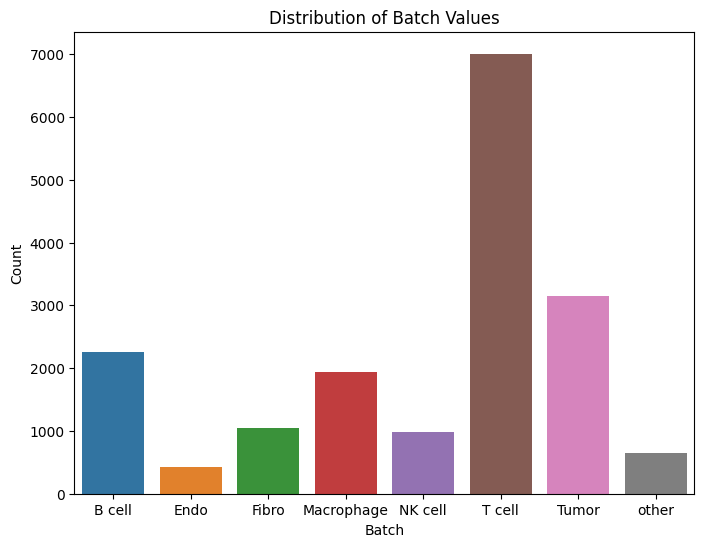

In [370]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设adata_filtered是筛选后的AnnData对象
# adata_filtered = ...

# 绘制batch列值的分布
plt.figure(figsize=(8, 6))
sns.countplot(x=adata.obs[:17462]['cell_type'])
plt.title('Distribution of Batch Values')
plt.xlabel('Batch')
plt.ylabel('Count')
plt.show()


/home/zengzw/anaconda3/envs/scrna/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


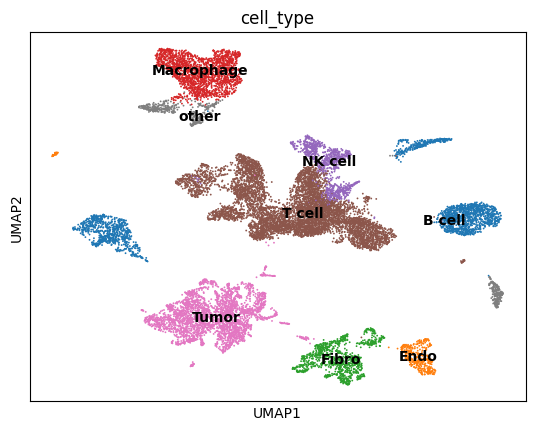

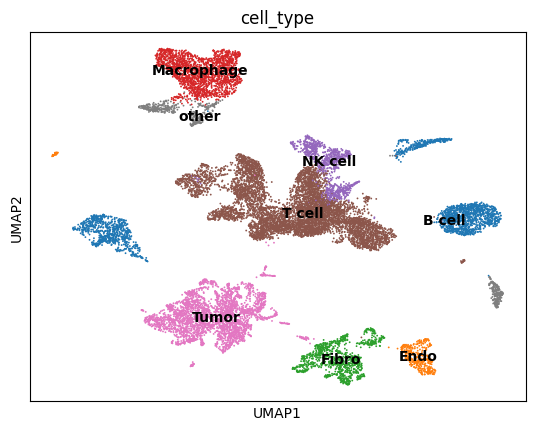

In [380]:
adata = sc.read_h5ad('/home/zengzw/prog/processed_data/GC_Zenglab'+'_modified'+'.h5ad')
adata = adata [:17462]
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata, maxiter=1000)
sc.pl.umap(adata, color='cell_type', legend_fontsize="medium", wspace=0.15, ncols=2, show=False, return_fig=True, legend_loc='on data')

In [375]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,discard,True,batch,leiden,louvain,cell_type,cdr3,cdr3_nt,V_gene,D_gene,J_gene,C_gene,barcode
0,2225,5596.0,80.0,1.429592490196228,True,5596.0,HAS01,0,1,T cell,/,/,/,/,/,/,AAACCTGAGCCACGCT
1,1370,3107.0,74.0,2.381718635559082,True,3107.0,HAS01,0,9,T cell,/,/,/,/,/,/,AAACCTGAGCTGCGAA
2,1890,4744.0,142.0,2.9932546615600586,True,4744.0,HAS01,10,11,NK cell,/,/,/,/,/,/,AAACCTGAGGTGACCA
3,1574,3186.0,20.0,0.6277464032173157,True,3186.0,HAS01,0,1,T cell,/,/,/,/,/,/,AAACCTGCAAACTGCT
4,1158,2202.0,125.0,5.676657676696777,True,2202.0,HAS01,4,3,B cell,/,/,/,/,/,/,AAACCTGCAAATACAG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21014,2791,22018.0,61.0,0.2770460546016693,True,22018.0,HAS05-copy,9,10,B cell,CARENTDESGSDFNWLDPW,TGTGCGAGGGAGAACACAGATGAATCGGGAAGTGATTTTAATTGGC...,IGHV4-4,NaN,IGHJ5,IGHG1,TTTGGTTCAAGGTGTG
21015,2791,22018.0,61.0,0.2770460546016693,True,22018.0,HAS05-copy,9,10,B cell,CQQSYNTRTF,TGTCAACAGAGTTACAATACCCGGACGTTC,IGKV1D-39,NaN,IGKJ1,IGKC,TTTGGTTCAAGGTGTG
21016,1313,3271.0,322.0,9.844083786010742,True,3271.0,HAS05-copy,4,3,B cell,CASAKTTLYSFDYW,TGTGCGAGCGCGAAAACAACTTTGTACTCCTTTGACTACTGG,IGHV4-39,NaN,IGHJ4,IGHM,TTTGGTTGTCCGAATT
21017,4573,27415.0,139.0,0.5070216655731201,True,27415.0,HAS05-copy,17,14,B cell,CAAWDDSLYGWVF,TGTGCAGCATGGGATGACAGCCTCTATGGTTGGGTGTTC,IGLV1-44,NaN,IGLJ3,IGLC2,TTTGTCAGTAAGGGAA


In [387]:
print("B cell: ", adata.obs.loc[adata.obs["cell_type"] == "B cell"].shape[0])
print("Tumor cell: ", adata.obs.loc[adata.obs["cell_type"] == "Tumor"].shape[0])

B cell:  2259
Tumor cell:  3146


In [373]:
# 计算每个cdr3序列出现的次数
cdr3_counts = adata.obs.loc[adata.obs['cell_type'] == 'B cell']['cdr3'].value_counts()

# 筛选出出现次数大于1的cdr3序列
duplicates = cdr3_counts[cdr3_counts > 5]

# 打印结果
print(duplicates)

# 如果需要查看具体哪些行出现了重复的cdr3，可以进一步筛选并打印出这些行
if not duplicates.empty:
    for cdr3_seq in duplicates.index:
        if(cdr3_seq == '/'):
            continue;
        print(f"重复的CDR3序列: {cdr3_seq}, 出现次数: {duplicates[cdr3_seq]}")
        # print(adata.obs[adata.obs['cdr3'] == cdr3_seq])
else:
    print("没有找到重复的CDR3序列。")

/                            2259
CMQALQIPPTF                    47
CARGYCSGGACYSADYW              33
CAGASENNRDYW                   30
CQQRSNWSRTF                    24
CARQKGNCSLSTCAWRFDPW           23
CAGDSENNRDYW                   22
CQQRSDWSRTF                    22
CQSGDINGLNIIF                  13
CTKDGQHLIPGSYFDLW              13
CQHYSTYSPLF                    10
CQVWEIAGDHYVF                   9
CQQSYSTPRTF                     9
CQQYGSSPLTF                     9
CAREYCTAGRCYGFDHW               9
CMQTLQIPPTF                     8
CVRTGEFTYQKKNQLWNYYCDLW         8
CARGNCGGGSCYSADYW               8
CQQYGSSPWTF                     8
CQHYSDYSPLF                     8
CGTWDDSLSAGGVF                  8
CQQYGSSPRTF                     8
CQSRDKSGNYVLF                   8
CTKDGQQLIPGSYFGLW               8
CARRRLVRGVFFDSW                 8
CQQRANWSRTF                     8
CGTWDSSLSAGVF                   7
CCSYAGSDIWVF                    7
CARIDRFSLYYYAMDVW               7
CQQSYSTPYTF   

In [277]:
adata.obs.loc[adata.obs['cell_type'] == 'Tumor']

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,discard,True,batch,leiden,louvain,cell_type,cdr3,cdr3_nt,barcode,V_gene
90,8843,53597.0,996.0,1.858312964439392,True,53597.0,HAS01,13,2,Tumor,/,/,AACACGTAGTGGTAAT,nan
153,3348,8786.0,806.0,9.173685073852539,True,8786.0,HAS01,8,2,Tumor,/,/,AACTCCCAGCTGCCCA,nan
168,1922,3375.0,115.0,3.407407522201538,True,3375.0,HAS01,8,2,Tumor,/,/,AACTCCCTCTTATCTG,nan
193,1010,5107.0,296.0,5.795966625213623,True,5107.0,HAS01,8,2,Tumor,/,/,AACTGGTTCAATACCG,nan
200,5528,28784.0,1494.0,5.190383434295654,True,28784.0,HAS01,8,2,Tumor,/,/,AACTTTCCATCGGTTA,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,2605,8144.0,795.0,9.761788368225098,True,8144.0,HAS05,23,2,Tumor,/,/,TTTATGCAGGACATTA,nan
17441,1997,3888.0,68.0,1.7489712238311768,True,3888.0,HAS05,23,2,Tumor,/,/,TTTGCGCCATACCATG,nan
17444,1277,2570.0,20.0,0.7782101035118103,True,2570.0,HAS05,6,6,Tumor,/,/,TTTGCGCTCGGTTAAC,nan
17459,7183,75615.0,2568.0,3.396151542663574,True,75615.0,HAS05,6,6,Tumor,/,/,TTTGTCATCGCTTAGA,nan
